Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [35]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [36]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [37]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [38]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [39]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [40]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory( data_dir_train,validation_split=0.2,subset="training",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [41]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,validation_split=0.2,subset="validation",seed=123,image_size=(img_height, img_width),batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [42]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [43]:
train_ds

<BatchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

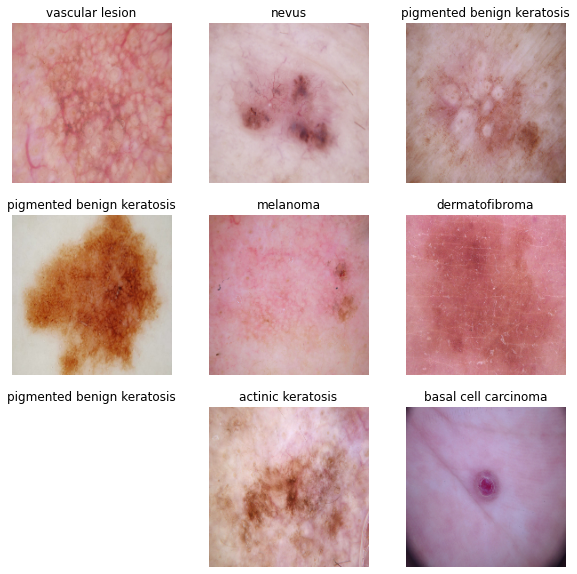

In [44]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for x in range(len(class_names)):
    ax=plt.subplot(3,3,x+1)
    idx=np.where(labels[:]==x)[0]
    if(len(idx)>0):
      n=idx[0]
      plt.imshow(images[n].numpy().astype('uint8'))
    plt.title(class_names[labels[x]])
    plt.axis('off')

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [45]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#Standardizing the data

In [46]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [47]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.09520731 1.0


### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [48]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [49]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [50]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 45, 45, 64)       

### Train the model

In [51]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 7s 114ms/step - loss: 2.0064 - accuracy: 0.2734 - val_loss: 1.7786 - val_accuracy: 0.3781
Epoch 2/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6573 - accuracy: 0.4152 - val_loss: 1.5050 - val_accuracy: 0.4541
Epoch 3/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4545 - accuracy: 0.4799 - val_loss: 1.4917 - val_accuracy: 0.5034
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.3788 - accuracy: 0.5296 - val_loss: 1.5078 - val_accuracy: 0.4765
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.2767 - accuracy: 0.5485 - val_loss: 1.3896 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.2189 - accuracy: 0.5614 - val_loss: 1.4072 - val_accuracy: 0.5101
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 1.1417 - accuracy: 0.5949 - val_loss: 1.4191 - val_accuracy: 0.5615
Epoch 8/20
5

### Visualizing training results

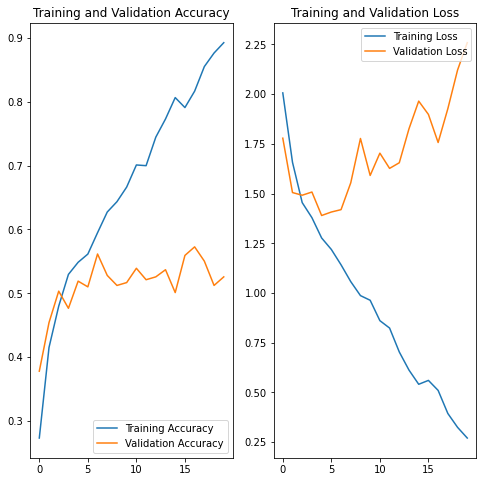

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
The plots show that in initial epochs training accuracy and validation accuracy both increased linearly but later validation accuracy settled to approximately 50% while training accuracy kept on increasing linearly with epoch.


Difference in accuracy of Training and validation is clear indication of overfitting

Overfitting is caused when there are small number of training examples and model sometimes learns from noises to an extent that, it negatively impacts the performance of model on new examples.

This can be avoided by data augmentation where additional training data from the existing examples will be generated by augmenting them using random transformations.

In [53]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

<Figure size 720x720 with 0 Axes>

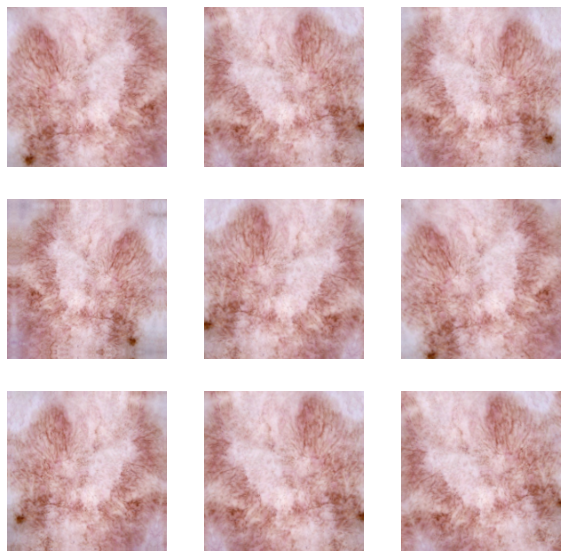

In [54]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")


### Todo:
### Create the model, compile and train the model


In [55]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])



### Compiling the model

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [57]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

### Training the model

In [58]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 67ms/step - loss: 1.9967 - accuracy: 0.2489 - val_loss: 1.7553 - val_accuracy: 0.4452
Epoch 2/20
56/56 [==============================] - 4s 64ms/step - loss: 1.6179 - accuracy: 0.4392 - val_loss: 1.5777 - val_accuracy: 0.4564
Epoch 3/20
56/56 [==============================] - 4s 64ms/step - loss: 1.4977 - accuracy: 0.4866 - val_loss: 1.4682 - val_accuracy: 0.4832
Epoch 4/20
56/56 [==============================] - 4s 64ms/step - loss: 1.3914 - accuracy: 0.5106 - val_loss: 1.3415 - val_accuracy: 0.5436
Epoch 5/20
56/56 [==============================] - 4s 64ms/step - loss: 1.4089 - accuracy: 0.5145 - val_loss: 1.4180 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.3048 - accuracy: 0.5374 - val_loss: 1.3790 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 4s 64ms/step - loss: 1.2749 - accuracy: 0.5575 - val_loss: 1.3284 - val_accuracy: 0.5414
Epoch 8/20
56

### Visualizing the results

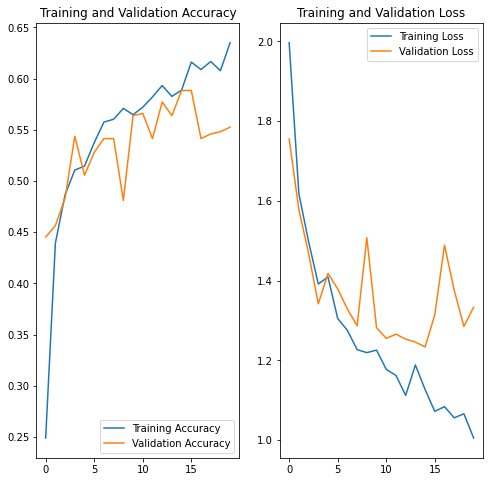

In [59]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Compared to previous model overfitting has drastically reduced after the addition of drop-out and augmentation layer.

This is evident from reduction in gap between training accuracy and validation accuracy 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [69]:
from pathlib import Path

In [70]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis")
ak1 = Path(data_dir_train).glob('**/*.jpg')
ak=len(list(ak1))
ak

114

In [71]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma")
bcc1 = Path(data_dir_train).glob('**/*.jpg')
bcc=len(list(bcc1))
bcc

376

In [72]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma")
dmat1 = Path(data_dir_train).glob('**/*.jpg')
dmat=len(list(dmat1))
dmat

95

In [73]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma")
mel1 = Path(data_dir_train).glob('**/*.jpg')
mel=len(list(mel1))
mel

438

In [74]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus")
nev1 = Path(data_dir_train).glob('**/*.jpg')
nev=len(list(nev1))
nev

357

In [75]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis")
pbk1 = Path(data_dir_train).glob('**/*.jpg')
pbk=len(list(pbk1))
pbk

462

In [76]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis")
sk1 = Path(data_dir_train).glob('**/*.jpg')
sk=len(list(sk1))
sk

77

In [77]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma")
scc1 = Path(data_dir_train).glob('**/*.jpg')
scc=len(list(scc1))
scc

181

In [78]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion")
vl1 = Path(data_dir_train).glob('**/*.jpg')
vl=len(list(vl1))
vl

139

In [91]:
count=pd.DataFrame(pd.Series({'ak':ak,'bcc':bcc,'dmat':95,'mel':mel,'nev':nev,'pbk':pbk,'sk':sk,'scc':scc,'vl':vl}))
count.columns=['count']
count['percent']=count['count']/sum(count['count'])
count

,count,percent
ak,114,0.050916
bcc,376,0.167932
dmat,95,0.042430
mel,438,0.195623
nev,357,0.159446
pbk,462,0.206342
sk,77,0.034390
scc,181,0.080840
vl,139,0.062081


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
Ans: sk i.e seborrheic keratosis with 77 samples
#### - Which classes dominate the data in terms proportionate number of samples?
Ans: pbk i.e pigmented benign keratosis with 20.6% samples in total data set

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [92]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [100]:
path_to_training_dataset='/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC02E255310>: 100%|██████████| 500/500 [00:22<00:00, 22.08 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBFB962D350>: 100%|██████████| 500/500 [00:22<00:00, 22.11 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBFB9955110>: 100%|██████████| 500/500 [00:23<00:00, 21.39 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7FBFB95FB250>: 100%|██████████| 500/500 [01:49<00:00,  4.57 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBFB864DAD0>: 100%|██████████| 500/500 [01:31<00:00,  5.46 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FBFB8745C50>: 100%|██████████| 500/500 [00:21<00:00, 22.96 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FBFB965E1D0>: 100%|██████████| 500/500 [00:49<00:00, 10.06 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FBFB971C950>: 100%|██████████| 500/500 [00:21<00:00, 23.59 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FC0A01CEC10>: 100%|██████████| 500/500 [00:22<00:00, 22.34 Samples/s]


In [102]:
data_dir_train = pathlib.Path(path_to_training_dataset)
print(data_dir_train)

/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [103]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [109]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026411.jpg_e3ac7cb4-4e3a-46b4-b43c-c6961eefe6bb.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0030827.jpg_465a06ba-c6ee-4d8d-b858-0b6ebf558178.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025808.jpg_33d0b072-c357-4ce7-b501-d478d85501b6.jpg',
 '/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0031119.jpg_2c1e6790-d1c5-444d-9007-07ba376a1058.jpg',
 '/conte

In [110]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [112]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [119]:
#df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [ ]:
#new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [115]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [122]:
data_dir_train='/content/drive/MyDrive/Colab Notebooks/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (img_height, img_width),
  batch_size = batch_size)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [124]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [132]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.13401027 0.92667854


In [157]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
   layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.1),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [158]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [159]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_37 (Conv2D)          (None, 180, 180, 4)       112       
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 90, 90, 4)        0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 90, 90, 8)         296       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 45, 45, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_39 (Conv2D)          (None, 45, 45, 16)      

#### **Todo:**  Train your model

In [160]:
epochs= 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 42s 236ms/step - loss: 2.1803 - accuracy: 0.1395 - val_loss: 2.1531 - val_accuracy: 0.1403
Epoch 2/30
169/169 [==============================] - 39s 226ms/step - loss: 1.8547 - accuracy: 0.2647 - val_loss: 1.6957 - val_accuracy: 0.3608
Epoch 3/30
169/169 [==============================] - 39s 225ms/step - loss: 1.6233 - accuracy: 0.3670 - val_loss: 1.5481 - val_accuracy: 0.4016
Epoch 4/30
169/169 [==============================] - 39s 223ms/step - loss: 1.4929 - accuracy: 0.4149 - val_loss: 1.5344 - val_accuracy: 0.4083
Epoch 5/30
169/169 [==============================] - 39s 223ms/step - loss: 1.4214 - accuracy: 0.4483 - val_loss: 1.3394 - val_accuracy: 0.4744
Epoch 6/30
169/169 [==============================] - 39s 223ms/step - loss: 1.3343 - accuracy: 0.4759 - val_loss: 1.2907 - val_accuracy: 0.4744
Epoch 7/30
169/169 [==============================] - 40s 226ms/step - loss: 1.2714 - accuracy: 0.5052 - val_loss: 1.3425 - val_ac

#### **Todo:**  Visualize the model results

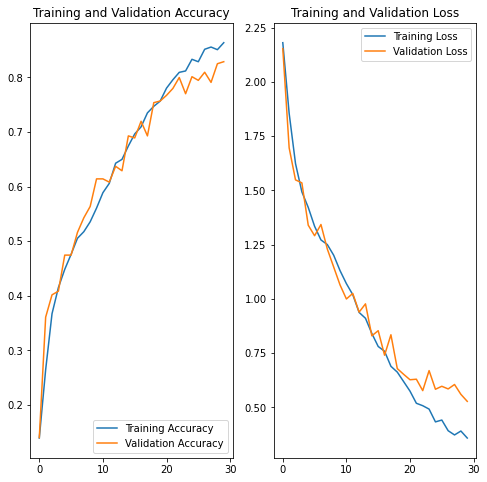

In [161]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



* Class rebalance definitely helped in reducing the overfitting as it is evident from above results
* To furthur solve problem of overfitting and to make our model more generic two dropout  layers were added in the model.
* Accuracy can be improved by adding more layers in model which will make the model computationally expensive.